# GEO1001 hw02 

### authors: Jasper van de Vaart, Noortje van der Horst
### student numbers: 4450752, 4697952

In [1]:
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import OPTICS

### Reading 10m data
The 10m resolution data is read in with the help of a 500x700 window, defined here. The data is read as floats, to remove the faulty horizontal lines witnessed when the datatype was not forced, and thus read as ints. The files are immediately closed after reading, to reduce the memory use of the clustering later on. Especially the DBSCAN clustering proved very memory-heavy (more on that later).

In [2]:
filepath = './GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA'

ds2_10 = rasterio.open(f'{filepath}/R10m/T31UET_20200530T105031_B02_10m.jp2', driver='JP2OpenJPEG') #blue
ds3_10 = rasterio.open(f'{filepath}/R10m/T31UET_20200530T105031_B03_10m.jp2', driver='JP2OpenJPEG') #green
ds4_10 = rasterio.open(f'{filepath}/R10m/T31UET_20200530T105031_B04_10m.jp2', driver='JP2OpenJPEG') #red
ds8_10 = rasterio.open(f'{filepath}/R10m/T31UET_20200530T105031_B08_10m.jp2', driver='JP2OpenJPEG') #NIR

x_coor_top = 601200.0
y_coor_top = 5773695.0
subset_height = 500
subset_width = 700
index_top_row, index_top_col = ds2_10.index(x_coor_top, y_coor_top)
window_subset = Window(index_top_col, index_top_row, subset_width, subset_height)

band2_10 = ds2_10.read(window=window_subset).astype(float)
band3_10 = ds3_10.read(window=window_subset).astype(float)
band4_10 = ds4_10.read(window=window_subset).astype(float)
band8_10 = ds8_10.read(window=window_subset).astype(float)

ds2_10.close()
ds3_10.close()
ds4_10.close()
ds8_10.close()

### Reading the 60m data

In [3]:
ds2_60 = rasterio.open(f'{filepath}/R60m/T31UET_20200530T105031_B02_60m.jp2', driver='JP2OpenJPEG') #blue
ds3_60 = rasterio.open(f'{filepath}/R60m/T31UET_20200530T105031_B03_60m.jp2', driver='JP2OpenJPEG') #green
ds4_60 = rasterio.open(f'{filepath}/R60m/T31UET_20200530T105031_B04_60m.jp2', driver='JP2OpenJPEG') #red
ds8_60 = rasterio.open(f'{filepath}/R60m/T31UET_20200530T105031_B8A_60m.jp2', driver='JP2OpenJPEG') #NIR
ds9_60 = rasterio.open(f'{filepath}/R60m/T31UET_20200530T105031_B09_60m.jp2', driver='JP2OpenJPEG') #WV
ds11_60 = rasterio.open(f'{filepath}/R60m/T31UET_20200530T105031_B11_60m.jp2', driver='JP2OpenJPEG') #SWIR

band2_60 = ds2_60.read().astype(float)
band3_60 = ds3_60.read().astype(float)
band4_60 = ds4_60.read().astype(float)
band8_60 = ds8_60.read().astype(float)
band9_60 = ds9_60.read().astype(float)
band11_60 = ds11_60.read().astype(float)

ds2_60.close()
ds3_60.close()
ds4_60.close()
ds8_60.close()
ds9_60.close()
ds11_60.close()

## Visualization

### Visualization of the cropped image, in (an approximation of) true color. 
This is just so see what is happening, and if the right window was used.

In [4]:
def normalize_clipped(array):
    # Returns normalized array, clipped to the 95th percentile.
    # The clipping to percentiles was done because outliers were 
    # creating a distorted (very black) true color image.
    array_min = np.percentile(array, 2.5)
    array_max = np.percentile(array, 97.5)
    array_clipped = np.clip(array, array_min, array_max)
    return ((array_clipped - array_min)/(array_max - array_min))


def normalize(array):
    array_min = np.min(array)
    array_max = np.max(array)
    return ((array - array_min)/(array_max - array_min))


def trueColor(blue, green, red, clipped):
    # Returns true color image, using the normalized red, green & blue bands (B4, B3, B2)
    if clipped:
        blue_nor = normalize_clipped(blue)
        green_nor = normalize_clipped(green)
        red_nor = normalize_clipped(red)
    else:
        blue_nor = normalize(blue)
        green_nor = normalize(green)
        red_nor = normalize(red)       
    rgb = np.dstack((red_nor, green_nor, blue_nor))
    return rgb

The first attempt at making a true color image just stacked the red, green and blue bands together, making pyplot try and automatically clip the data to a valid RGB range ([0,1] or [0,255]). This did not work, the output was a single white image. We then normalized the data first, to manually schale the data to a [0,1] range. This also did not work, it produced a very dark image (see below). We made sure to check if we read the data as floats, and compared the min, max and mean values of the bands. The values were slightly different, which was to be expected, but the maximum values were way higher than we expected to be possible (https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric). We do not know what caused these outliers, but we elected to clip the input data to a 95% confidence interval, which took care of all outliers and produced a (seemingly) correct TCI.

Text(0.5,1,'Non-clipped TCI')

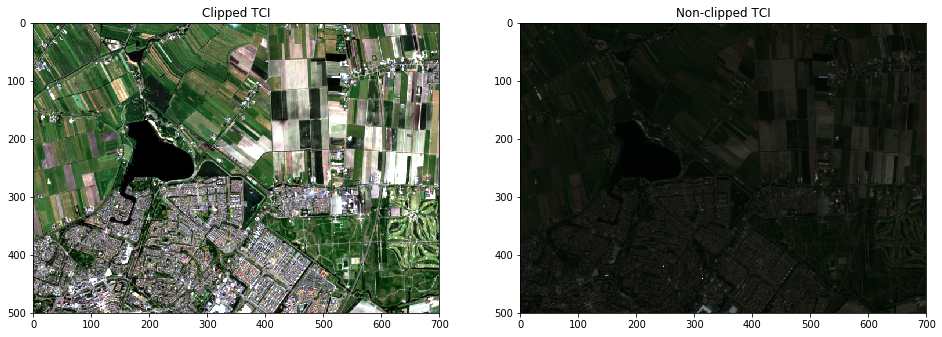

In [5]:
blue_10 = np.reshape(band2_10, (subset_height, subset_width)) 
green_10 = np.reshape(band3_10, (subset_height, subset_width))
red_10 = np.reshape(band4_10, (subset_height, subset_width))

c_tci_10 = trueColor(blue_10, green_10, red_10, clipped=True)
n_tci_10 = trueColor(blue_10, green_10, red_10, clipped=False)

pyplot.figure(figsize=(16, 20))
pyplot.subplot(121)
pyplot.imshow(c_tci_10)
pyplot.title("Clipped TCI")

pyplot.subplot(122)
pyplot.imshow(n_tci_10)
pyplot.title("Non-clipped TCI")


### Visualization of the 60m image, in (an approximation of) true color

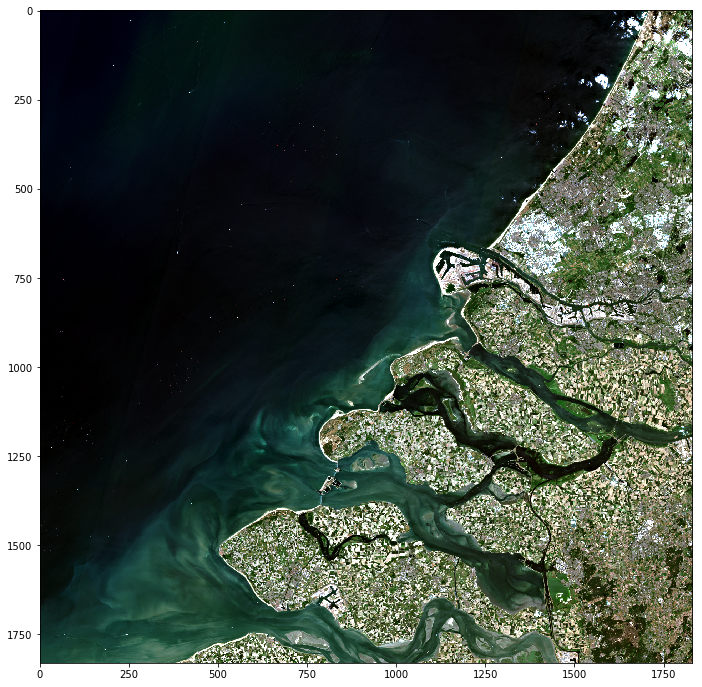

In [6]:
blue_60 = np.reshape(band2_60, (ds2_60.height, ds2_60.width))
green_60 = np.reshape(band3_60, (ds2_60.height, ds2_60.width))
red_60 = np.reshape(band4_60, (ds2_60.height, ds2_60.width))

tci_60 = trueColor(blue_60, green_60, red_60, clipped=True)

pyplot.figure(figsize=(12, 12))
pyplot.imshow(tci_60)

## K-means clustering

In [7]:
def Formatting(bands):
    res = []
    for band in bands:
        res.append(band.flatten())
    return np.stack((tuple(res)), axis=1)

def KmeansClustering(bands, nr_clusters, times):
    data_formatted = Formatting(bands)
    kmeans = KMeans(init='k-means++', n_clusters=nr_clusters, n_init=times).fit_predict(data_formatted)
    return kmeans

    
def KmeansPCA(data, s_cluster):
    data_formatted = Formatting(data)
    reduced_data = PCA(n_components=2).fit_transform(data_formatted)
    kmeans = s_cluster
    
    pyplot.figure(figsize=(8, 8))
    pyplot.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans)
    pyplot.title("k-means: PCA")
    pyplot.show()   

## DBSCAN clustering

In [8]:
def dbscanClustering(bands, dist, neighbours):
    print("running")
    data_formatted = Formatting(bands)
    print("executing DBSCAN")
    dbscan = DBSCAN(eps=dist, min_samples=neighbours, algorithm='kd_tree').fit_predict(data_formatted) 
    return dbscan


def dbscanPCA(data, db_clusters):
    data_formatted = Formatting(data)
    reduced_data = PCA(n_components=2).fit_transform(data_formatted)
    dbscan = db_clusters
    
    pyplot.figure(figsize=(8, 8))
    pyplot.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan)
    pyplot.title("DBSCAN: PCA")
    pyplot.show()


def dbscanImage(clusters):
    
    image = pyplot.imshow(clusters, cmap="Set1")

    # generate legend
    # note: the colormap used for this image only works up until nr_clusters <= 10(it only has 10 colors)
    classes = []
    unique = np.unique(clusters)
    for i in unique:
        norm_i = ((i - min(unique)) / (max(unique) - min(unique)))
        classes.append(norm_i)    
    colors = [image.cmap(c) for c in classes]
    patches = [ plt.patches.Patch(color=colors[i], label="Cluster {l}".format(l=i) ) for i in unique]
    pyplot.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    
    pyplot.show()

## Helpers

In [9]:
def NDVI(red, nir):
    ndvi = (nir - red) / (nir + red)
    return ndvi


def NDSI(green, swir):
    ndsi = (green - swir) / (green + swir)
    return ndsi


def plotClusterCount(categories):
    unique, counts = np.unique(categories, return_counts=True)
    res = dict(zip(unique, counts))
    
    pyplot.bar(unique, counts)
    pyplot.xticks(unique)
    pyplot.xlabel("cluster")
    pyplot.ylabel("pixel count")
    pyplot.title("cluster distribution")
    pyplot.show()
    
    print(res)

## NDVI filtering

## Clustering for 10m resolution
For the clustering of the 10m resolution, we elected to use all bands available to us, plus a generated NDVI band. We use all bands for both the k-means and the DBSCAN clustering, but the datasets are defined seperately for better customizability and bugtesting.

In [10]:
blue_10 = np.reshape(band2_10, (subset_height, subset_width))
green_10 = np.reshape(band3_10, (subset_height, subset_width))
red_10 = np.reshape(band4_10, (subset_height, subset_width))
nir_10 = np.reshape(band8_10, (subset_height, subset_width))
ndvi_10 = NDVI(red_10, nir_10)

data_10_kmeans = np.stack((blue_10, green_10, red_10, nir_10, ndvi_10), axis=0)
data_10_dbscan = np.stack((blue_10, green_10, red_10, nir_10, ndvi_10), axis=0)

## K-means

### k-means: initiations
The number of initiations for the k-means clustering was chosen by first using the default value, 10, and comparing that with the result of doubling and halving that value. There is no big difference between these values, and the distribution and location of clusters when using 10 initiations does not seem to be explicitly wrong (see below). We therefor elected to use 10 initiations for the 10m resolution images.

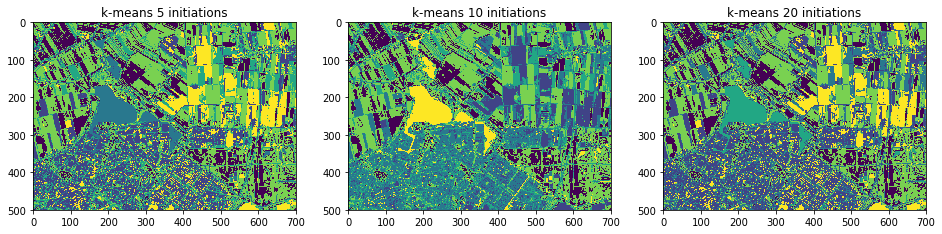

In [11]:
simple_clusters5 = KmeansClustering(data_10_kmeans, 6, 5)
simple_clusters10 = KmeansClustering(data_10_kmeans, 6, 10)
simple_clusters20 = KmeansClustering(data_10_kmeans, 6, 20)


clusters5 = np.reshape(simple_clusters5, (data_10_kmeans.shape[1], data_10_kmeans.shape[2]))
clusters10 = np.reshape(simple_clusters10,(data_10_kmeans.shape[1], data_10_kmeans.shape[2]))
clusters20 = np.reshape(simple_clusters20,(data_10_kmeans.shape[1], data_10_kmeans.shape[2]))

pyplot.figure(figsize=(16, 20))

pyplot.subplot(131)
pyplot.imshow(clusters5)
pyplot.title("k-means 5 initiations")

pyplot.subplot(132)
pyplot.imshow(clusters10)
pyplot.title("k-means 10 initiations")

pyplot.subplot(133)
pyplot.imshow(clusters20)
pyplot.title("k-means 20 initiations")

pyplot.show()

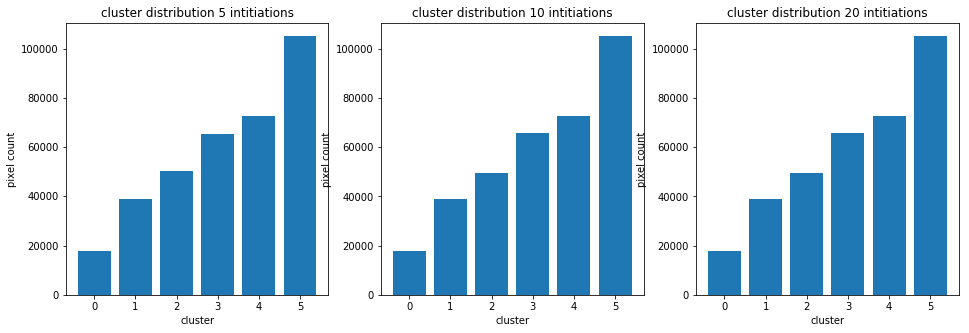

In [12]:
unique5, counts5 = np.unique(simple_clusters5, return_counts=True)
unique10, counts10 = np.unique(simple_clusters10, return_counts=True)
unique20, counts20 = np.unique(simple_clusters20, return_counts=True)

pyplot.figure(figsize=(16, 5))

pyplot.subplot(131)
pyplot.bar(unique5, sorted(counts5))
pyplot.xticks(unique5)
pyplot.xlabel("cluster")
pyplot.ylabel("pixel count")
pyplot.title("cluster distribution 5 intitiations")

pyplot.subplot(132)
pyplot.bar(unique10, sorted(counts10))
pyplot.xticks(unique5)
pyplot.xlabel("cluster")
pyplot.ylabel("pixel count")
pyplot.title("cluster distribution 10 intitiations")

pyplot.subplot(133)
pyplot.bar(unique10, sorted(counts10))
pyplot.xticks(unique5)
pyplot.xlabel("cluster")
pyplot.ylabel("pixel count")
pyplot.title("cluster distribution 20 intitiations")

pyplot.show()

It was difficult to compare the different cluster images, because the nature of k-means clustering means clusters do not get assigned in a set order. This meant that the same clusters would have different colors in different images. This also meant that when making the bar plots comparing the clusters in ascending order, it did not matter which number was assigned to which cluster, since this number could change when the algorithm was performed again.

### k-means: image
K-means clustering, with each pixel colored according to its assigned cluster value. Our own true color image is displayed next to it, in order to be able to compare clusters to reality. The number of clusters was determined by trying to find different possible classifications that the algorithm may be able to determine:
- buildings
- grass
- trees/forests
- roads
- water
- greenhouses

These clusters seem to correspond quite clearly with the true color image. Water is picked out really well. There is even some distinction between types of foliage, where grass and trees are often classified separately. Buildings are also picked out, but the distinction between this categories and other things is not perfect. The class containing most of the buildings also contains some similarly-colored fields, with the same thing happening for the class containing (most) roads. After inspection on google maps greenhouses do not seem to be present in the area, but k-means did make a distinction between very white barren fields and fields with (more) vegetation.

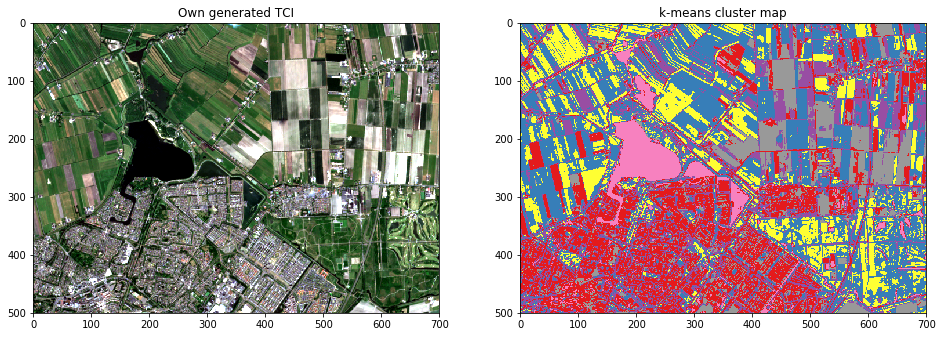

In [13]:
pyplot.figure(figsize=(16, 20))
    
pyplot.subplot(121)
pyplot.imshow(c_tci_10)
pyplot.title("Own generated TCI")
    
pyplot.subplot(122)
pyplot.title("k-means cluster map")
pyplot.imshow(clusters10, cmap="Set1")

pyplot.show()

### k-means: PCA
We used different variations of visualizing the k-means clustering. Visualization of k-means clustering beyond two dimensions is not straightforward. The Principal Component Analysis version below reduces the data to the two most varying (aka most important) dimensions. Because the clustering is now reduced to 2D, it can be visualized easily in a scatterplot. A scatterplot shows clearly whether the algoritm has made logical clusters (for these dimensions). A downside is that it cannot show clustering for higher dimensions, and so does not provide a complete image of all data used for the clustering.

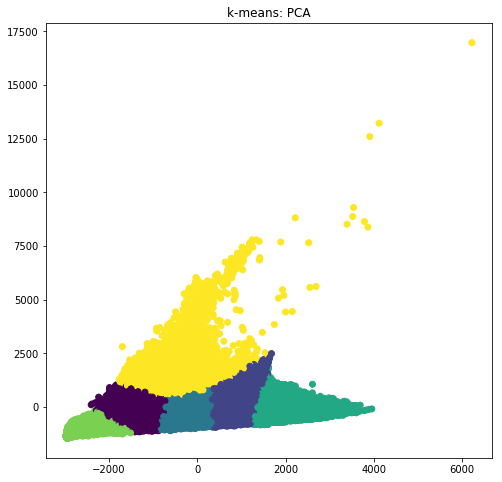

In [14]:
KmeansPCA(data_10_kmeans, simple_clusters10)

Clusters are not easy to spot, and are right next no eachother. It is also clearly visible that k-means classification does not pick out outliers. However, the image comparison showed that k-means did manage to pick out some categories of land cover. So although the clusters in the barplot are very close to eachother, it is likely they are at least partially based on real life distinctions.

### k-means: cluster counts
This bar plot was made to see the distribution among the clusters for non-PCA k-means clustering. It is hard to spot this from an image alone. The plot shows a clear distinction between clusters, with no extremely large or small clusters present.  There is a plausible number of pixels assigned to each cluster. This plot does not show how the pixels in each cluster relate to each-other, like the scatterplot, so it is not possible to determine much more about how well the algorithm assigned the data. The exact counts for each cluster are printed below the plot for easier comparison.

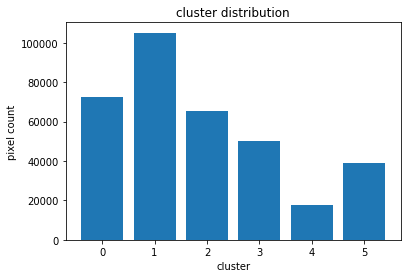

{0: 72682, 1: 105156, 2: 65513, 3: 50198, 4: 17665, 5: 38786}


In [15]:
plotClusterCount(simple_clusters10)

## DBSCAN

### DBSCAN: neighborhood distance & number of neighbours
The most important parameter of the DBSCAN clustering is the neighborhood distance. The bigger the eps, the larger the radius of a neighborhood, or cluster. The memory use of the algorithm also significantly increases as the eps gets larger. We tried to find a good value for this parameter by trying out different combinations of eps and nr of neighbors, optimizing for least number of outliers (cluster = -1), logical number of clusters found (between 3 and 10), and computational space. This was done using barplots, so we could easily oversee what the distribution within the clusters was. We added 2 print statements to check wether the program had crashed, since the DBSCAN can take a long time. If "running" and "executing DBSCAN" are not appearing as texts within a minute or so when running, something went wrong.

running
executing DBSCAN


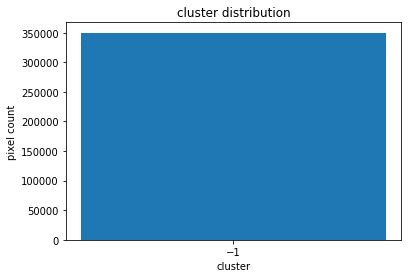

{-1: 350000}


In [21]:
plotClusterCount(dbscanClustering(data_10_dbscan, 1, 10))

running
executing DBSCAN


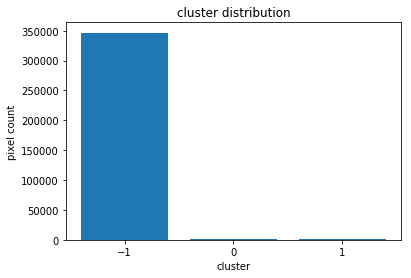

{-1: 346654, 0: 1968, 1: 1378}


In [22]:
plotClusterCount(dbscanClustering(data_10_dbscan, 10, 100))

running
executing DBSCAN


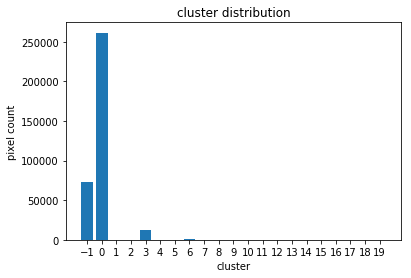

{-1: 73084, 0: 261333, 1: 358, 2: 358, 3: 12705, 4: 278, 5: 213, 6: 385, 7: 103, 8: 139, 9: 60, 10: 50, 11: 349, 12: 112, 13: 81, 14: 115, 15: 78, 16: 102, 17: 29, 18: 36, 19: 32}


In [23]:
plotClusterCount(dbscanClustering(data_10_dbscan, 50, 50))

running
executing DBSCAN


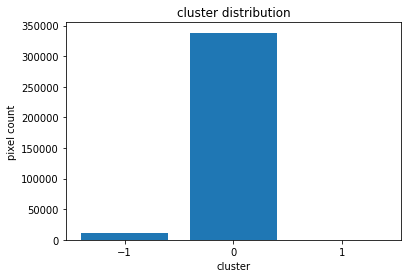

{-1: 11363, 0: 338274, 1: 363}


In [24]:
plotClusterCount(dbscanClustering(data_10_dbscan, 100, 100))

running
executing DBSCAN


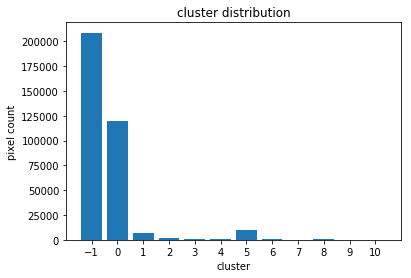

{-1: 208560, 0: 119261, 1: 6544, 2: 2250, 3: 892, 4: 1149, 5: 9923, 6: 445, 7: 246, 8: 444, 9: 136, 10: 150}


In [25]:
plotClusterCount(dbscanClustering(data_10_dbscan, 50, 150))

running
executing DBSCAN


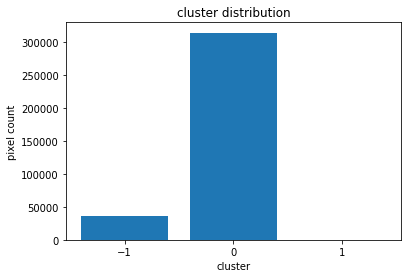

{-1: 35700, 0: 314182, 1: 118}


In [26]:
plotClusterCount(dbscanClustering(data_10_dbscan, 80, 150))

running
executing DBSCAN


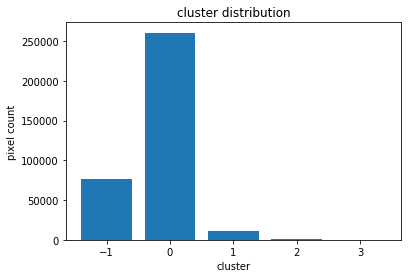

{-1: 76825, 0: 260609, 1: 10774, 2: 1577, 3: 215}


In [13]:
cluster_db = dbscanClustering(data_10_dbscan, 65, 150)
plotClusterCount(cluster_db)

It can be seen that for the parameters 1, 10 and 10, 100 too many pixels get identified as ouliers: eps is not big enough. For 100, 100 almost no pixels are outliers, but there is only 2 classes found, with a large majority of the data belonging to one class. 50, 50 finds a large number of classes, but the assigment is very skewed with a lot of outliers still. 200, 200 took too long to run, so eps will have to be smaller than that. It seems the bigger the eps, the fewer outliers are found, but that first very big cluster grows as well. We tried to find a balance between this: eps=80 seems to be too much, and 50 too little. We settled on using eps=65 and nr_nbrs = 150. This results in 4 clusters found, with 76.825 outliers.

### DBSCAN: image

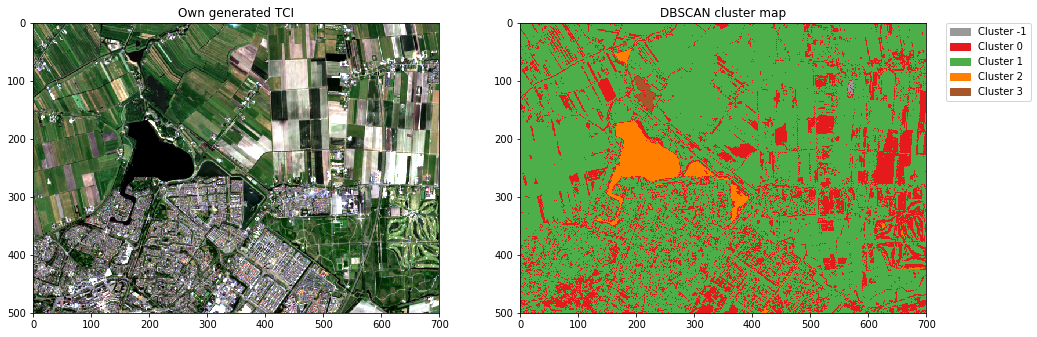

In [14]:
pyplot.figure(figsize=(16, 20))

pyplot.subplot(121)
pyplot.imshow(c_tci_10)
pyplot.title("Own generated TCI")

pyplot.subplot(122)
pyplot.title("DBSCAN cluster map")

dbscanImage(np.reshape(cluster_db, (data_10_dbscan.shape[1], data_10_dbscan.shape[2])))

The image shows that DBSCAN, like k-means, also managed to pick out water really well, although the k-means seems to be a little bit more exact. DBSCAN also assigned some of the water to a separate class. As for the other clusters found, there are two clearly visible ones, and one very small one. The outliers are colored gray, and appear to be located mostly in one spot in the upper right corner. Comparing the location with google maps showed a greenhouse in approximately this location. This was for as far as we could find the only greenhouse in the area. K-means did not pick this up. DBSCAN assigned most of the fields to the same, relatively very big cluster. The other big cluster mostly seems to correspond with lighter-colored areas. DBSCAN also did not pick out buldings very well. In this case, k-means seems to be the preferable clustering method.

### DBSCAN: PCA

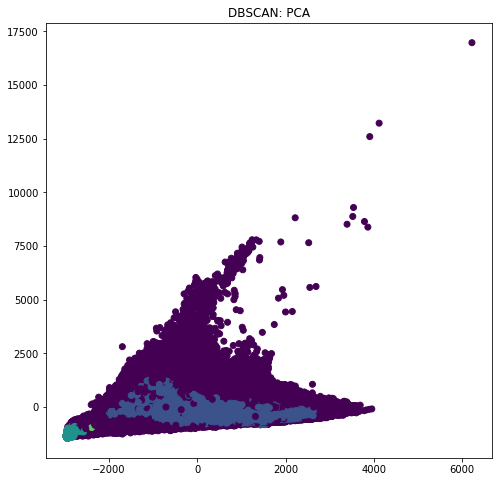

In [18]:
dbscanPCA(data_10_dbscan, cluster_db)

Interesting is that the shape of this PCA scatterplot is very similar to the one of the k-means. It is likely that the same 2 axes were used. The plot only shows 2 large classes, with one of them "folding" around the others, containing all the outliers. The fourth cluster is not visible in the plot, it was likely too small. Clusters are not very distinct in the scatterplot, it is interesting how different clusters still do seem to relate to certain features when visualized in an image. For DBSCAN as well, reducing complexity with PCA is not very beneficial in this case. It is also visible that k-means likely classified better, even taking into account it does not separate outliers.

## Clusterig for 60m resolution

In [15]:
def nvdiAdjusted(bands_NDVI, bands_NIR, bands_WV):
    adj1_bands_NDVI = np.empty_like(bands_NDVI)
    adj2_bands_NDVI = np.empty_like(bands_NDVI)

    inter = input('remove cloud data? (Y/N): ')

    for i in range(len(bands_NDVI)):
        for j in range(len(bands_NDVI[i])):

            # check for NIR reflection (low == water)
            if bands_NIR[i,j] < 1000:
                adj1_bands_NDVI[i,j] = -0.6
                adj2_bands_NDVI[i,j] = -0.6
            #check for low water evaporation (low could mean city) 
            elif bands_WV[i,j] < 2300:
                adj1_bands_NDVI[i,j] = bands_NDVI[i,j] #adj1 is excluded from the evaporation correction
                #keep water and city values seperated
                if bands_NDVI[i,j]-0.5 > -0.3:
                    adj2_bands_NDVI[i,j] = bands_NDVI[i,j]-0.5
                else:
                    adj2_bands_NDVI[i,j] = -0.3
            #check for high water evaporation (high could mean cloud) 
            elif bands_WV[i,j] > 6500:
                    adj1_bands_NDVI[i,j] = bands_NDVI[i,j] #adj1 is excluded from the cloud correction
                    if inter.lower() == 'y':
                        adj2_bands_NDVI[i,j] = float('NaN')
                    else:
                        adj2_bands_NDVI[i,j] = bands_NDVI[i,j]

            else:
                adj1_bands_NDVI[i,j] = bands_NDVI[i,j]
                adj2_bands_NDVI[i,j] = bands_NDVI[i,j]
    
    # attempted intepolation of NaNs
    if inter.lower() == 'y':
        nans = np.isnan(adj2_bands_NDVI)
        x = lambda z: z.nonzero()[0]
        adj2_bands_NDVI[nans] = np.interp(x(nans), x (~nans), adj2_bands_NDVI[~nans])
        
    return adj1_bands_NDVI, adj2_bands_NDVI

def nvdiAdjPlot(bands_NDVI, adj1_bands_NDVI, adj2_bands_NDVI):
    fig = pyplot.figure(figsize=(16,6))

    ax1 = pyplot.subplot(131)
    ax2 = pyplot.subplot(132)
    ax3 = pyplot.subplot(133)

    ax1.set_title('unadjusted NDVI')
    ax1.imshow(bands_NDVI)
    ax2.set_title('water adjusted NDVI')
    ax2.imshow(adj1_bands_NDVI)
    ax3.set_title('water + evaporation adjusted NDVI')
    ax3.imshow(adj2_bands_NDVI)

    pyplot.show()

In [16]:
blue_60 = np.reshape(band2_60, (band2_60.shape[1], band2_60.shape[2]))
green_60 = np.reshape(band3_60, (band2_60.shape[1], band2_60.shape[2]))
red_60 = np.reshape(band4_60, (band2_60.shape[1], band2_60.shape[2]))
nir_60 = np.reshape(band8_60, (band2_60.shape[1], band2_60.shape[2]))
wv_60 = np.reshape(band9_60, (band2_60.shape[1], band2_60.shape[2]))
swir_60 = np.reshape(band11_60, (band2_60.shape[1], band2_60.shape[2]))
ndvi_60 = NDVI(red_60, nir_60)
ndsi_60 = NDSI(green_60, swir_60)

data_60_kmeans = np.stack((blue_60, green_60, red_60, nir_60, ndvi_60), axis=0)
data_60_dbscan = np.stack((green_60, ndvi_60), axis=0)

## K-means

### NDVI and NDSI
For the 60m image, we decided to try and do some filtering of the clouds in the image. For this, we fisrt visualized the NDVI and NDSI. The NDSI and the NDVI are calculated via the formulas supplied by: https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm. Both are plotted to see if they have valueable attributes to use in the classification (although snow might not be an issue in this map). The NDVI shows more information on the land surface, while the NDSI shows a very clear seperation between land and water masses.

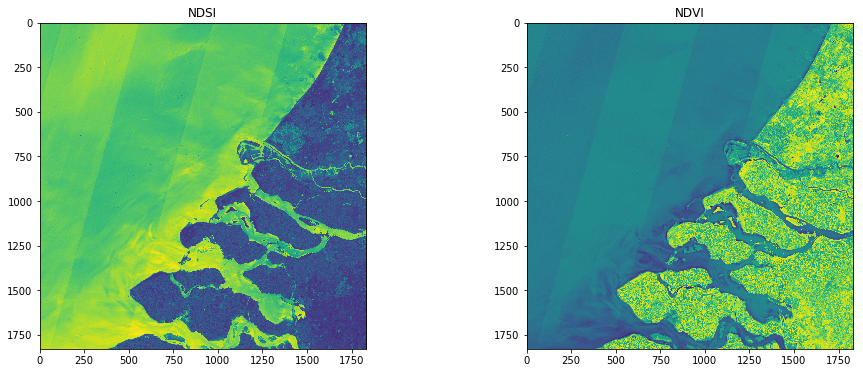

In [21]:
fig = pyplot.figure(figsize=(16,6))
ax1 = pyplot.subplot(121)
ax2 = pyplot.subplot(122)

ax1.set_title('NDSI')
ax1.imshow(ndsi_60)
ax2.set_title('NDVI')
ax2.imshow(ndvi_60)

pyplot.show()

### NDVI adjustment
Although the NDSI shows water and land serperation very well, the decision was made to again use the NIR and not the calculated NDSI to mask out the water on the NDVI. Water absorbs NIR better than land does (source: https://sustainenvironres.biomedcentral.com/articles/10.1186/s42834-019-0016-5). With this information, a filter was made to change the values of the NDVI to -0.6 if the NIR value of the pixel was smaller than 1000.

Added to this we noticed that cities tend to have lower water evaporation values. This is the base of the second filter. The pixel value of the NDVI is reduced with 0.5 if the water evaporation value of the pixel was less than 2300. This filter caused a problem however, some of these pixels got very similar values to the earlier filtered 'water' pixels. To seperate the two, the NDSI values were only reduced by -0.5 if the resulting value remained bigger than -0.3 (-0.6 were the 'water' pixels). If this was not the case, the NDSI pixel would get a value of -0.3 instead of a reduction of 0.5.

On the water evaporation map we also noticed that the clouds had extremely high values. The pixel value of the NDVI was replaced with a 'NaN' if the value of the water evaporation was bigger than 6500. In the next kernel these 'NaN's were attempted to be interpolated out. The result however was not succesfull, so we decided to ask the user if they want to "remove the could data".

We plotted the three results (the unadjusted NDVI, the NDVI filtered with the NIR information, and the NDVI filtered with both the NIR and water evaporation filter). The difference between the unadjusted NDVI and NIR filtered NDVI are very clear. Where the water areas in the NDVI have a similar color to some parts of the land mass the NIR filtered NDVI has very destinct water areas. The difference between the NIR filtered NDVI and the NIR + Water evaportation filtered NDVI is less clear. On the NIR + water evaportation filtered NDVI the locations of cities can be recognized easier. Where the NIR filtered NDVI only shows the port of Rotterdam, on this one the city of Rotterdam, The Hague, Leiden, Bergen op Zoom and Roosendaal can also be located.

remove cloud data? (Y/N): y


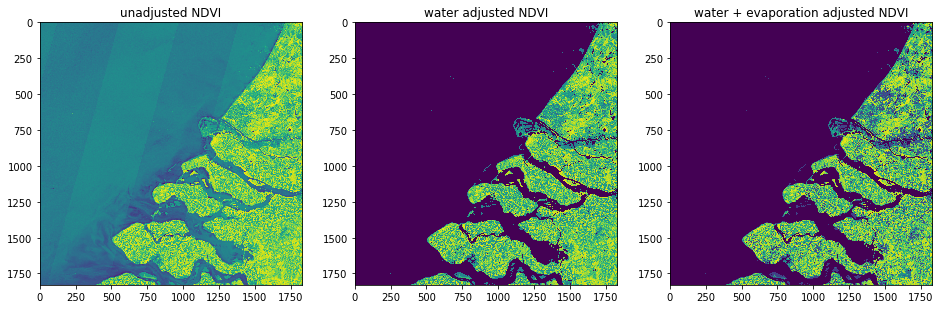

In [17]:
ndvi_60_water, ndvi_60_clouds = nvdiAdjusted(ndvi_60, nir_60, wv_60)
nvdiAdjPlot(ndvi_60, ndvi_60_water, ndvi_60_clouds)

### k-means: image

We performed k-means clustering for the three created maps (the unadjusted NDVI, the NDVI filtered with the NIR information and the NDVI filtered with both the NIR and water evaporation filter). We have chosen to use 5 clusters here, because both adjusted NDVI maps show distinct possible categories: water, two types of nature, and two types city areas. It is likely one of the types of nature overlaps with one of the city categories. In addition, if 6 or more clusters are chosen fragmentation of the clusters is so big that it also becomes very hard to regognize areas on the map. We decided to again stick with the default number of initializations.

In [58]:
# x1_cluster = KmeansClustering(data_60_kmeans, 5, 10)
# x2_cluster = KmeansClustering(ndvi_60_water, 5, 10)

simple_cluster_k = KmeansClustering(np.expand_dims(ndvi_60, axis=0), 5, 10)
simple_cluster_wk = KmeansClustering(np.expand_dims(ndvi_60_water, axis=0), 5, 10)
simple_cluster_c = KmeansClustering(np.expand_dims(ndvi_60_clouds, axis=0), 5, 10)

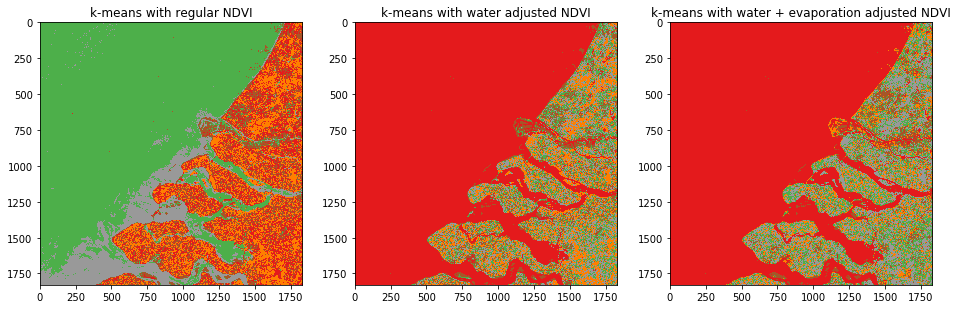

In [41]:
cluster_k = np.reshape(simple_cluster_k,(data_60_kmeans.shape[1], data_60_kmeans.shape[2]))
cluster_wk = np.reshape(simple_cluster_wk,(data_60_kmeans.shape[1], data_60_kmeans.shape[2]))
cluster_c = np.reshape(simple_cluster_c,(data_60_kmeans.shape[1], data_60_kmeans.shape[2]))


pyplot.figure(figsize=(16, 20))
    
pyplot.subplot(131)
pyplot.title('k-means with regular NDVI')
pyplot.imshow(cluster_k, cmap="Set1")

pyplot.subplot(132)
pyplot.title('k-means with water adjusted NDVI')
pyplot.imshow(cluster_wk, cmap="Set1")

pyplot.subplot(133)
pyplot.title('k-means with water + evaporation adjusted NDVI')
pyplot.imshow(cluster_c, cmap="Set1")

pyplot.show()

It is unfortunate that k-means clustering does not assign clusters in a set order. This makes the color of clusters differ from plot to plot, making it hard to compare different images. From the images above it is however clear that k-means again picks out water really well. When the NDVI is adjusted, the clusering no longer confuses the sand banks around the cost as a different category than water. It is clear that with only using these bands, k-means will already make a plausible distinction between water, areas with a lot of vegeteation, and cities.

### k-means: initiations and number of clusters
We decided to also perform k-means clustering for the RGB bands available to us, together with the NIR and water + evaporation adjusted NDVI. We compared this with the clustering with the original NDVI.

In [21]:
data_60_kmeans_com = np.stack((blue_60, green_60, red_60, nir_60, ndvi_60_clouds), axis=0)

simple_cluster_all = KmeansClustering(data_60_kmeans_com, 5, 10)
cluster_all = np.reshape(simple_cluster_all,(data_60_kmeans_com.shape[1], data_60_kmeans_com.shape[2]))

simple_cluster_si = KmeansClustering(data_60_kmeans, 5, 10)
cluster_si = np.reshape(simple_cluster_si,(data_60_kmeans.shape[1], data_60_kmeans.shape[2]))

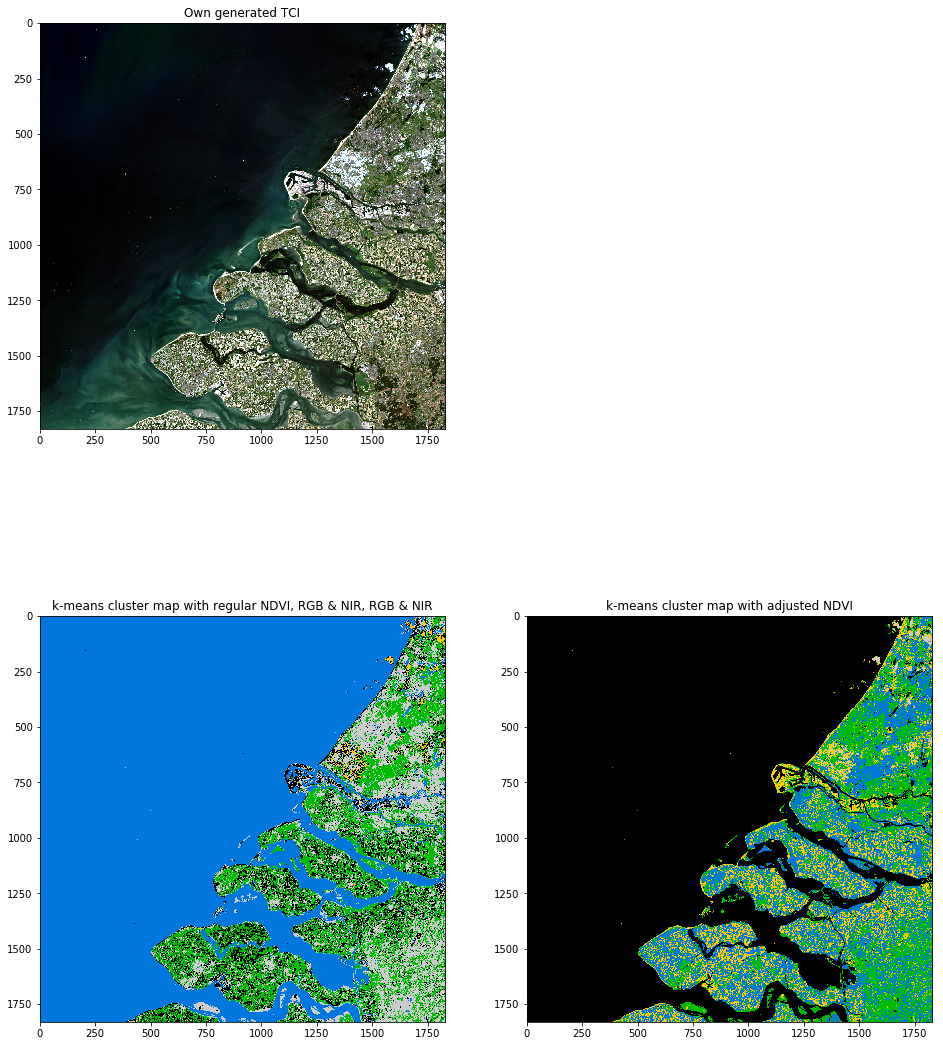

In [59]:
pyplot.figure(figsize=(16, 20))
    
pyplot.subplot(221)
pyplot.imshow(tci_60)
pyplot.title("Own generated TCI")
   
pyplot.subplot(223)
pyplot.title("k-means cluster map with regular NDVI, RGB & NIR, RGB & NIR")
pyplot.imshow(cluster_si, cmap="nipy_spectral")

pyplot.subplot(224)
pyplot.title("k-means cluster map with adjusted NDVI")
pyplot.imshow(cluster_all, cmap="nipy_spectral")

pyplot.show()


The k-means seems to pick out water better when the rgb bands are included, even when using the regular NDVI. Difference between regular and adjusted NDVI seems small, but comparison is difficult with the clusters having different colors.

### k-means: PCA

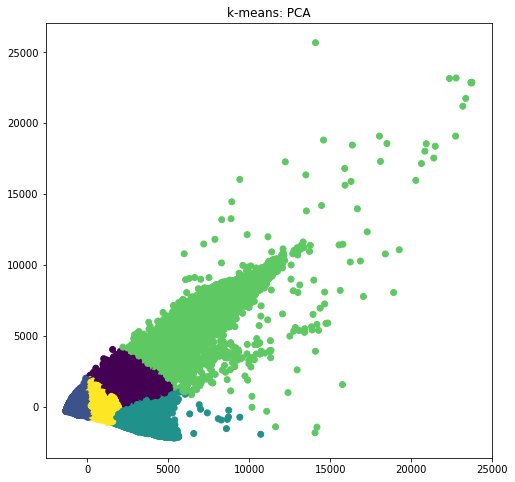

In [23]:
KmeansPCA(data_60_kmeans, simple_cluster_si)

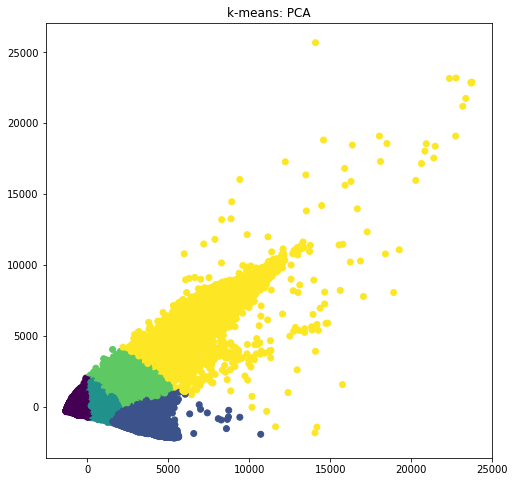

In [24]:
KmeansPCA(data_60_kmeans_com, simple_cluster_all)

The difference between unadjusted (above) and adjusted (below) NDVI is again very small. The outliers were assigned to the same cluster for both. The shape of these scatterplots is noticably similar to the ones of the 10m data, although they do differ.

### k-means: cluster counts

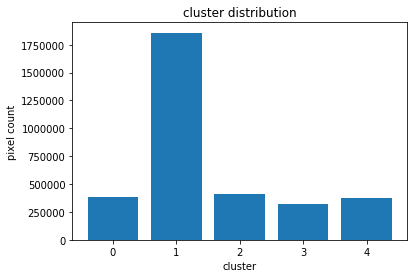

{0: 386351, 1: 1858254, 2: 412186, 3: 318656, 4: 373453}


In [57]:
plotClusterCount(simple_cluster_k)

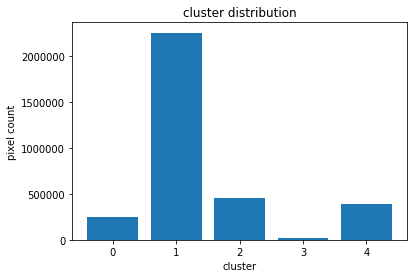

{0: 242369, 1: 2249298, 2: 457483, 3: 15334, 4: 384416}


In [55]:
plotClusterCount(cluster_si)

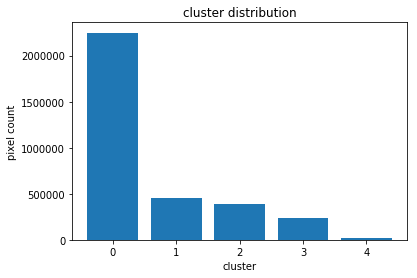

{0: 2249203, 1: 458373, 2: 383962, 3: 242117, 4: 15245}


In [56]:
plotClusterCount(cluster_all)

Ordered cluster counts:
- {0: 1.858.254, 1: 412.186, 2: 386.351, 3: 373.453, 4: 318.656}
- {0: 2.249.298, 1: 457.483, 2: 384.416, 3: 242.369, 4: 15.334}
- {0: 2.249.203, 1: 458.373, 2: 383.962, 3: 242.117, 4: 15.245}

The first bar plot shows the distribution for the k-means clustering of only the NDVI. The second and third plot show all data with the NDVI unadjusted and adjusted respectively. The smallest cluster of all data clustering is a factor 10 smaller than the smallest of only the NDVI. The largest cluster of only NDVI is also significantly smaller. The largest cluster corresponds to water areas, it makes sense that just the unfiltered NDVI would be worse at finding water. The difference between the adjusted and unadjusted clustering with all bands is relatively very small. When using more bands than just adjusted or unadjusted NDVI, it seems filtering did not have an impact on the k-means clustering.

## DBSCAN
Unfortunately, we did not manage to perform DBSCAN clustering of the 60m resolution, due to memory issues. We tried a range of values for the neighborhood size and minimum samples parameters (from 0.2 to 10000 for eps, and 2 to 200 for min_samples), but did not manage to run it. The sklearn docs (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN) provided some advice on reducing complexity, which we tried out. The below snippet of code provides an alternative for the dbscanClustering method,  pre-computing sparse neighborhoods with sklearn.NearestNeighbors. However, this operation still used too much memory to run, and always crashed due to memory issues before it could start the dbscan itself. We also looked at possible algorithms sklearn's DBSCAN can use to find neighborhoods (https://scikit-learn.org/stable/modules/neighbors.html). Since we were working with a very large sample size (N = 1830 x 1830 = 3.348.900 and D = 2 (we used just 2 bands for testing)), we also tried using the KD tree algorithm specifically. The docs also mentioned OPTICS as a possible less heavy alternative, so we also tried using that. This did not produce any memory issues, but instead kept running for multiple hours, so we had to sadly give up.

### OPTICS: image

In [ ]:
def opticsClustering(bands, dist, neighbours):
    print("running")
    res = []
    for band in bands:
        res.append(band.flatten())
    data = np.stack((tuple(res)), axis=1)
    print("executing")
    doptics = OPTICS(min_samples=neighbours, max_eps=dist).fit_predict(data) 
    return optics

In [ ]:
clusters = opticsClustering(data_60_dbscan, 5, 5)
clusters = np.reshape(clusters, (data_60_dbscan.shape[1], data_60_dbscan.shape[2]))

pyplot.figure(figsize=(16, 20)) 
image = pyplot.imshow(clusters, cmap="Set1")
pyplot.title("OPTICS cluster map")
pyplot.show()

### DBSCAN: image

In [ ]:
def dbscanClusteringAlternative(bands, dist, neighbours):
    print("running")
    res = []
    for band in bands:
        res.append(band.flatten())
    data = np.stack((tuple(res)), axis=1)
    print("computing distance matrix")
    neigh = NearestNeighbors(radius=dist)
    neigh.fit(data)
    distance_matrix = neigh.radius_neighbors_graph(data, mode='distance') 
    print("executing DBSCAN")
    dbscan = DBSCAN(eps=dist, min_samples=neighbours, algorithm='kd_tree',
                    metric='precomputed').fit_predict(distance_matrix) 
    return dbscan

In [ ]:
print(data_60_dbscan.shape)

slection_min = 1300
selection_max = 1700

data_60_sc = data_60_dbscan[:, slection_min:selection_max, slection_min:selection_max]

cluster_db_60 = dbscanClustering(data_60_sc, 100, 100)
dbscanImage(np.reshape(cluster_db_60, (data_60_dbscan.shape[1], data_60_dbscan.shape[2])))

pyplot.subplot(122)
pyplot.title("windowed dbscan")
pyplot.imshow(data_60_dbscan[:, slection_min:selection_max, slection_min:selection_max], cmap="Set1")

pyplot.show()